# Sarsa(λ) – Forward View (λ‑return)

In [4]:

import numpy as np, matplotlib.pyplot as plt, pickle, pathlib
from env import BlackjackEnv
from tqdm import trange
from collections import defaultdict

env = BlackjackEnv(seed=1)

# Load MC ground truth
with open('mc_Q_star.pkl', 'rb') as f:
    Q_star = pickle.load(f)

def mse(Q_hat):
    """
    Mean-squared error between Q_hat and the Monte-Carlo ground truth Q_star.
    Each dict key is a STATE tuple (dealer_face, player_sum), and each value
    is a length-2 ndarray holding [Q(s,stick), Q(s,hit)].
    """
    err   = 0.0
    count = 0
    for state, q_star_vec in Q_star.items():        # q_star_vec is length-2
        q_hat_vec = Q_hat.get(state, np.zeros(2))   # default [0,0] if unseen
        err      += ((q_hat_vec - q_star_vec) ** 2).sum()   # sum over both actions
        count    += 2
    return err / count


### Helper: λ‑return

In [5]:

def lambda_return(rewards, t, lam):
    G = 0.0
    lam_pow = 1.0
    for n in range(1, len(rewards)-t):
        G_n = rewards[t+1:t+n+1].sum()
        G += lam_pow * (1-lam) * G_n
        lam_pow *= lam
    G += lam_pow * rewards[-1]
    return G


### Run experiments for λ ∈ {0,0.1,…,1}

In [6]:

lam_grid = np.linspace(0,1,11)
mse_per_lam = []
episodes = 1000
for lam in lam_grid:
    Q_hat = defaultdict(lambda: np.zeros(2))
    alpha = 0.01
    mses = []
    for ep in range(episodes):
        s = env.reset()
        episode_states, episode_actions, episode_rewards = [], [], [0]
        done=False
        # generate episode
        while not done:
            # ε-greedy with constant ε=0.1
            if np.random.rand() < 0.1:
                a = np.random.randint(2)
            else:
                q_vals = Q_hat[(s[0], s[1])]
                a = np.random.choice(np.flatnonzero(q_vals == q_vals.max()))
            episode_states.append(s)
            episode_actions.append(a)
            s_next, r, done = env.step(a)
            episode_rewards.append(r)
            s = s_next if not done else (None, None)
        # forward view updates
        T = len(episode_states)
        for t in range(T):
            G_lam = lambda_return(np.array(episode_rewards), t, lam)
            key = (episode_states[t][0], episode_states[t][1]), episode_actions[t]
            Q_hat[key[0]][key[1]] += alpha * (G_lam - Q_hat[key[0]][key[1]])
        # log mse
        mses.append(mse(Q_hat))
    mse_per_lam.append(mses[-1])
    print(f"λ={lam:.1f}  final MSE={mses[-1]:.4f}")


λ=0.0  final MSE=0.2301
λ=0.1  final MSE=0.2302
λ=0.2  final MSE=0.2299
λ=0.3  final MSE=0.2298
λ=0.4  final MSE=0.2293
λ=0.5  final MSE=0.2299
λ=0.6  final MSE=0.2300
λ=0.7  final MSE=0.2298
λ=0.8  final MSE=0.2297
λ=0.9  final MSE=0.2298
λ=1.0  final MSE=0.2297


### Plot MSE vs λ

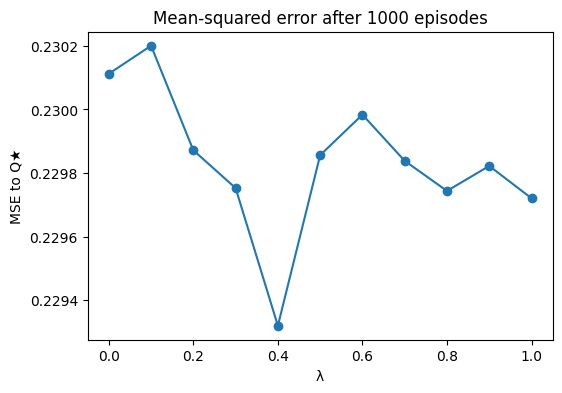

In [7]:

plt.figure(figsize=(6,4))
plt.plot(lam_grid, mse_per_lam, marker='o')
plt.xlabel('λ')
plt.ylabel('MSE to Q★')
plt.title('Mean‑squared error after 1000 episodes')
pathlib.Path('plots').mkdir(exist_ok=True)
plt.savefig('plots/mse_vs_lambda.png')
plt.show()
